In [1]:
import numpy as np
import pandas as pd
from deepgo.utils import Ontology
from collections import Counter
import obonet
import networkx as nx
import nxontology
from nxontology import NXOntology
from nxontology.imports import pronto_to_multidigraph, multidigraph_to_digraph, pronto_to_nxontology
import pronto
import fastobo
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Load all GO terms

In [2]:
all_go = Ontology('go.obo', with_rels=True)

bp_rels = {}
mf_rels = {}
cc_rels = {}

for term_id, term_data in all_go.ont.items():
    # Check the namespace of the term
    namespace = term_data['namespace']
    if namespace == 'biological_process':
        bp_rels[term_id] = term_data
    elif namespace == 'molecular_function':
        mf_rels[term_id] = term_data
    elif namespace == 'cellular_component':
        cc_rels[term_id] = term_data

bp = list(bp_rels.keys())
mf = list(mf_rels.keys())
cc = list(cc_rels.keys())
print(len(bp_rels))
print(len(mf_rels))
print(len(cc_rels))

mf_root = "GO:0003674"
bp_root = "GO:0008150"
cc_root = "GO:0005575"
roots = [mf_root, bp_root, cc_root]

30591
12266
4421


### Load data

In [3]:
species = "thaliana_exp"

train_bp_df = pd.read_pickle(f'data/bp/{species}_train.pkl')
val_bp_df = pd.read_pickle(f'data/bp/{species}_valid.pkl')
test_bp_df = pd.read_pickle(f'data/bp/{species}_test.pkl')

train_mf_df = pd.read_pickle(f'data/mf/{species}_train.pkl')
val_mf_df = pd.read_pickle(f'data/mf/{species}_valid.pkl')
test_mf_df = pd.read_pickle(f'data/mf/{species}_test.pkl')

train_cc_df = pd.read_pickle(f'data/cc/{species}_train.pkl')
val_cc_df = pd.read_pickle(f'data/cc/{species}_valid.pkl')
test_cc_df = pd.read_pickle(f'data/cc/{species}_test.pkl')

train_df = pd.concat([train_bp_df, train_mf_df, train_cc_df], axis=0, ignore_index=True)
val_df = pd.concat([val_bp_df, val_mf_df, val_cc_df], axis=0, ignore_index=True)
test_df = pd.concat([test_bp_df, test_mf_df, test_cc_df], axis=0, ignore_index=True)

In [4]:
def get_terms(data):
    """Get GO terms from data subsets (train, val, test)"""
    cnt = Counter()
    for i, row in data.iterrows():
        for term in row['prop_annotations']:
            cnt[term] += 1
    terms = list(cnt.keys())
    print(f"Number of terms: {len(terms)}")
    return terms

In [5]:
train = get_terms(train_df)
val = get_terms(val_df)
test = get_terms(test_df)

Number of terms: 7598
Number of terms: 4852
Number of terms: 4056


### Load GO graph and calculate node depth

In [6]:
# Load GO graph using pronto
go_pronto = pronto.Ontology("go.obo")
go_multidigraph = pronto_to_multidigraph(go_pronto)
go_digraph = multidigraph_to_digraph(go_multidigraph, reduce=False)

# Get node depth
def get_node_depth(root, node):
    """Calculate depth of node from the root"""
    depth = 0
    for path in nx.shortest_simple_paths(go_digraph, root, node):
        depth = max(depth, len(path))
    return depth

In [7]:
train_depth_bp = {}
train_depth_mf = {}
train_depth_cc = {}
val_depth_bp = {}
val_depth_mf = {}
val_depth_cc = {}
test_depth_bp = {}
test_depth_mf = {}
test_depth_cc = {}

for node in train:
    if node in bp:
        depth = get_node_depth(bp_root, node)
        train_depth_bp[node] = depth
    if node in mf:
        depth = get_node_depth(mf_root, node)
        train_depth_mf[node] = depth
    if node in cc:
        depth = get_node_depth(cc_root, node)
        train_depth_cc[node] = depth

for node in val:
    if node in bp:
        depth = get_node_depth(bp_root, node)
        val_depth_bp[node] = depth
    if node in mf:
        depth = get_node_depth(mf_root, node)
        val_depth_mf[node] = depth
    if node in cc:
        depth = get_node_depth(cc_root, node)
        val_depth_cc[node] = depth

for node in test:
    if node in bp:
        depth = get_node_depth(bp_root, node)
        test_depth_bp[node] = depth
    if node in mf:
        depth = get_node_depth(mf_root, node)
        test_depth_mf[node] = depth
    if node in cc:
        depth = get_node_depth(cc_root, node)
        test_depth_cc[node] = depth

In [8]:
# print(len(train_depth_bp))
# print(len(train_depth_mf))
# print(len(train_depth_cc))

# print(len(val_depth_bp))
# print(len(val_depth_mf))
# print(len(val_depth_cc))

# print(len(test_depth_bp))
# print(len(test_depth_mf))
# print(len(test_depth_cc))

### Histogram

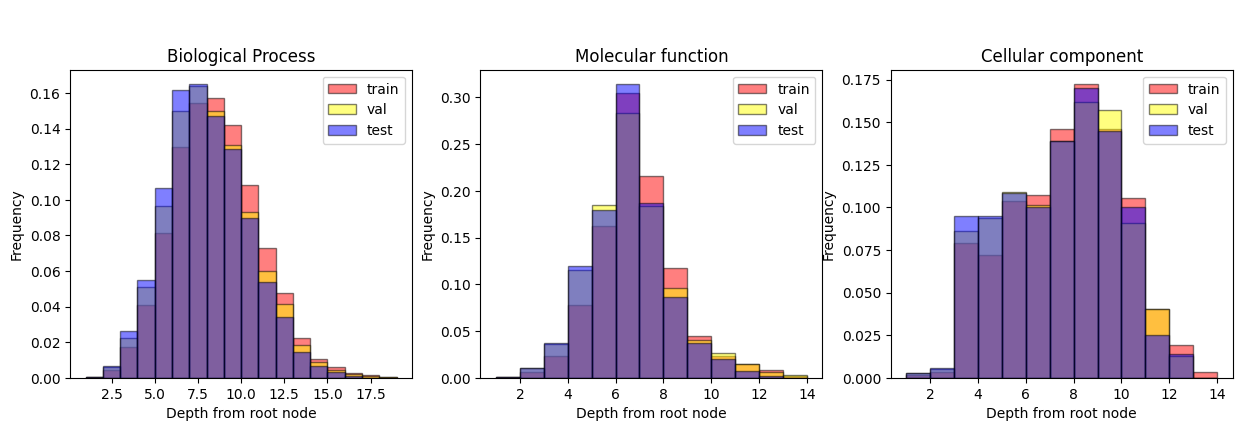

In [9]:
figure, axis = plt.subplots(1, 3, figsize=(15, 4)) 
d = True

bins = np.arange(min(min(train_depth_bp.values()), min(val_depth_bp.values()), min(test_depth_bp.values())), 
                 max(max(train_depth_bp.values()), max(val_depth_bp.values()), max(test_depth_bp.values())) + 1.5, 1) 
axis[0].hist(list(train_depth_bp.values()), bins=bins, edgecolor='black', color='red', alpha=0.5, label="train", density=d)
axis[0].hist(list(val_depth_bp.values()), bins=bins, edgecolor='black', color='yellow', alpha=0.5, label="val", density=d)
axis[0].hist(list(test_depth_bp.values()), bins=bins, edgecolor='black', color='blue', alpha=0.5, label="test", density=d)
axis[0].set_xlabel('Depth from root node')
axis[0].set_ylabel('Frequency')
axis[0].set_title('Biological Process')
axis[0].legend()

bins = np.arange(min(min(train_depth_mf.values()), min(val_depth_mf.values()), min(test_depth_mf.values())), 
                 max(max(train_depth_mf.values()), max(val_depth_mf.values()), max(test_depth_mf.values())) + 1.5, 1)  
axis[1].hist(list(train_depth_mf.values()), bins=bins, edgecolor='black', color='red', alpha=0.5, label="train", density=d)
axis[1].hist(list(val_depth_mf.values()), bins=bins, edgecolor='black', color='yellow', alpha=0.5, label="val", density=d)
axis[1].hist(list(test_depth_mf.values()), bins=bins, edgecolor='black', color='blue', alpha=0.5, label="test", density=d)
axis[1].set_xlabel('Depth from root node')
axis[1].set_ylabel('Frequency')
axis[1].set_title('Molecular function')
axis[1].legend()

bins = np.arange(min(min(train_depth_cc.values()), min(val_depth_cc.values()), min(test_depth_cc.values())), 
                 max(max(train_depth_cc.values()), max(val_depth_cc.values()), max(test_depth_cc.values())) + 1.5, 1) 
axis[2].hist(list(train_depth_cc.values()), bins=bins, edgecolor='black', color='red', alpha=0.5, label="train", density=d)
axis[2].hist(list(val_depth_cc.values()), bins=bins, edgecolor='black', color='yellow', alpha=0.5, label="val", density=d)
axis[2].hist(list(test_depth_cc.values()), bins=bins, edgecolor='black', color='blue', alpha=0.5, label="test", density=d)
axis[2].set_xlabel('Depth from root node')
axis[2].set_ylabel('Frequency')
axis[2].set_title('Cellular component')
axis[2].legend()

figure.suptitle(' ', fontsize=16, verticalalignment='bottom')
# plt.savefig(f"/Users/ngoc/All/ict/gene_pred/AAA-last-reports/figs/go/{species}_dist.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

### Box plots with ANOVA test results + Tukey post hoc

In [12]:
def plot_anova_boxplots(data, labels, title, position, axes):
    """Plot node depths and display ANOVA test statistics"""
    train, val, test = data
    f_stat, p_val = stats.f_oneway(list(train.values()), list(val.values()), list(test.values()))
    significance = '*' if p_val < 0.05 else ''
    
    axes[position].boxplot(
        [list(train.values()), list(val.values()), list(test.values())],
        tick_labels=['Train', 'Val', 'Test'],
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', color='black'),
        medianprops=dict(color='red')
    )
    
    axes[position].set_title(f"{title}\n(p={p_val:.3f}{significance})", fontsize=12)
    axes[position].set_ylabel('Depth from root node')

    if p_val < 0.05:  #if ANOVA is significant, perform Tukey's HSD test
        combined_data = pd.DataFrame({
            'value': np.concatenate([list(train.values()), list(val.values()), list(test.values())]),
            'group': ['Train'] * len(train) + ['Val'] * len(val) + ['Test'] * len(test)
        }) 
        tukey_result = pairwise_tukeyhsd(combined_data['value'], combined_data['group'])
        print(tukey_result.summary())  # the summary of Tukey's test

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Test  Train   0.5456    0.0  0.4091  0.6822   True
  Test    Val    0.212 0.0021  0.0651  0.3589   True
 Train    Val  -0.3336    0.0 -0.4628 -0.2043   True
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Test  Train    0.379    0.0  0.2193 0.5388   True
  Test    Val   0.1393 0.1721 -0.0429 0.3214  False
 Train    Val  -0.2398 0.0005 -0.3885 -0.091   True
---------------------------------------------------


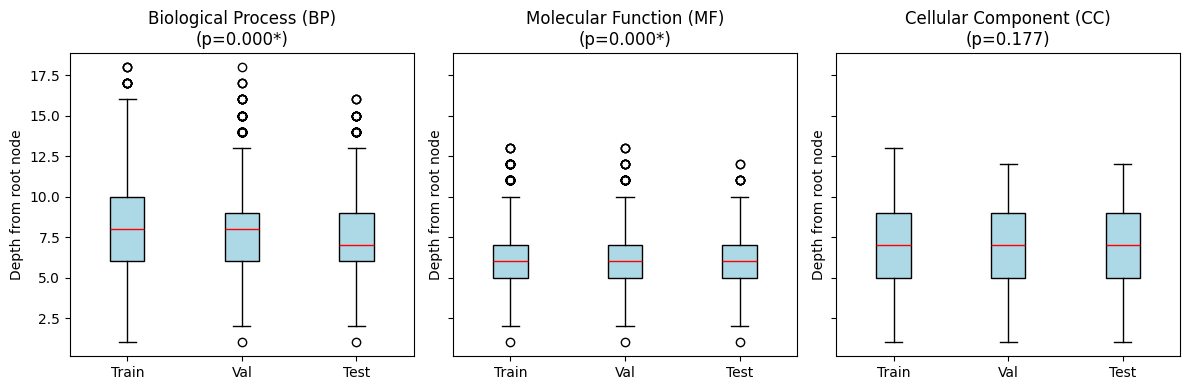

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

plot_anova_boxplots([train_depth_bp, val_depth_bp, test_depth_bp], ['Train', 'Val', 'Test'], 'Biological Process (BP)', 0, axes)
plot_anova_boxplots([train_depth_mf, val_depth_mf, test_depth_mf], ['Train', 'Val', 'Test'], 'Molecular Function (MF)', 1, axes)
plot_anova_boxplots([train_depth_cc, val_depth_cc, test_depth_cc], ['Train', 'Val', 'Test'], 'Cellular Component (CC)', 2, axes)

plt.tight_layout()
plt.show()